In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import estnltk
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
from math import sqrt
from gensim.models.keyedvectors import KeyedVectors
# from numba import jit, autojit
from sklearn.manifold import MDS, TSNE
import glob
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
model = KeyedVectors.load_word2vec_format('word2vec-models/lemmas.cbow.s100.w2v.bin', binary=True)

In [4]:
model

### Lemmatize the octacorpus

In [ ]:
def lemmatize(sentence):
    lemma_sentence = " ".join(estnltk.Text(sentence.strip()).lemmas)
    return  lemma_sentence
    
lemmatize(sentence)

In [ ]:
with tqdm(open("../datasets/octacorpus.txt")) as corpus_file:
    lemmatized_sentences = Parallel(n_jobs=30)(delayed(lemmatize)(sentence) for sentence in corpus_file)

### To create new dataset by filtering the octacorpus, based on a word, run the two following cells.

In [29]:
lemma_sentences = open("../datasets/octakorpus/octacorpus_lemmatized.txt").readlines()
word_sentences = open("../datasets/octakorpus/octacorpus.txt").readlines()

In [56]:
word_to_sentences('mesikäpp')

mesikäpp


In [58]:
# words = ['Eesti', 'Saksamaa', 'Soome', 'Itaalia', 'Leedu', 'Šveits', '']

countries = ['Saksamaa', 'Prantsusmaa', 'Inglismaa', 'Soome', 'Hispaania', 'Läti', 'Rootsi', 'Eesti', 'Holland', 'Šveits']

cities = ['Berliin', 'Pariis', 'London', 'Helsingi', 'Madrid', 'Riia', 'Stockholm', 'Tallinn', 'Amsterdam', 'Zürich']

def word_to_sentences(word):
    print(word)
    filtered_lemma_sentences = []
    filtered_word_sentences = []

    for i, lemma_sentence in enumerate(lemma_sentences):
        lemma_words = lemma_sentence.split()
        if len(lemma_words) <= 1:
            continue
        if word in lemma_words:
            filtered_lemma_sentences.append(lemma_sentence)
            filtered_word_sentences.append(word_sentences[i])

    open('../datasets/sentences/{}_lemmatized.txt'.format(word), 'w').writelines(filtered_lemma_sentences)
    open('../datasets/sentences/{}_word.txt'.format(word), 'w').writelines(filtered_word_sentences)

In [46]:
Parallel(n_jobs=20)(delayed(word_to_sentences)(word) for word in countries + cities)

Saksamaa
Prantsusmaa
Inglismaa
Soome
Hispaania
Läti
Rootsi
Eesti
Holland
Berliin
Helsingi
Pariis
London
Šveits
Madrid
Riia
Stockholm
Amsterdam
Tallinn
Zürich


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [59]:

word1_sentences = open('../datasets/contexts/tee_jook_contexts_s_True_w_4.txt').readlines()


### Lemma file --> contexts {window,symmety}

In [40]:
sent = 'Kõrvalosades on Eesti komitee , loomeliidud , ERSP ja Saksamaa ainuke laip - interliikumine .'

In [46]:
sentence_to_contexts('countries', sent, True, 2)

[{'lemma_context': 'kõrvalosa olema komitee loomeliit',
  'word_context': 'kõrvalosades on komitee loomeliidud'},
 {'lemma_context': 'loomeliit ersp ainuke laip',
  'word_context': 'loomeliidud ersp ainuke laip'}]

In [58]:
success_indexes = []

countries = ['Saksamaa', 'Prantsusmaa', 'Inglismaa', 'Soome', 'Hispaania', 'Läti', 'Rootsi', 'Eesti', 'Holland', 'Šveits']
cities = ['Berliin', 'Helsingi', 'Pariis', 'London', 'Madrid', 'Riia', 'Stockholm', 'Amsterdam', 'Tallinn', 'Zürich']

def sentence_to_contexts(word, sentence, symmetric, window_size):
    sentence_text = estnltk.Text(sentence)
    df = sentence_text.get.word_texts.lemmas.postags.postag_descriptions.as_dataframe
    df = df[(df.postags != 'Z') & (df.postags != 'J')].reset_index()
    # the usual case.
    indexes = df.loc[df.lemmas==word].index
    # special cases
    if word == 'countries':
        indexes = df.loc[df.lemmas.isin(countries)].index
    if word == 'cities':
        indexes = df.loc[df.lemmas.isin(cities)].index
    if word == 'TallinnTartu':
        indexes = df.loc[df.lemmas.isin(['Tallinn', 'Tartu'])].index
    
    results = []
    for index in indexes:
        left_context = " ".join(df.word_texts[max(index-window_size,0):index])
        right_context = " ".join(df.word_texts[index+1:index+window_size+1])
        word_context = "{} {}".format(left_context, right_context).strip().lower()
        lemma_left_context = " ".join(df.lemmas[max(index-window_size,0):index])
        lemma_right_context = " ".join(df.lemmas[index+1:index+window_size+1])
        lemma_context = "{} {}".format(lemma_left_context, lemma_right_context).strip().lower()
        
        if symmetric and (len(left_context.split()) != window_size or len(right_context.split()) != window_size):
            continue
        try:
            model[lemma_context.split()]
            results.append({'word_context': word_context, 'lemma_context': lemma_context})
        except KeyError:
            pass
        except ValueError:
            pass
    return results


def sentences_to_contexts(word, sentences, symmetric, window_size):
    word_contexts = []
    lemma_contexts = []
    for i, sentence in enumerate(sentences):
        if i %1000 == 0:
            print(word, i)
        contexts = sentence_to_contexts(word, sentence, symmetric=symmetric, window_size=window_size)
        for context in contexts:
            word_contexts.append(context['word_context'])
            lemma_contexts.append(context['lemma_context'])
    return {'word_contexts': word_contexts, 'lemma_contexts': lemma_contexts}


In [60]:
# apple_sentences = open('../datasets/oun_word.txt').readlines()
# rock_sentences = open('../datasets/kivi_word.txt').readlines()
# pear_sentences = open('../datasets/pirn_word.txt').readlines()

words = [('joogitee', 'sõidutee'),
        ('õun', 'banaan'),
        ('õun', 'puder'),
        ('õun', 'kivi'),
        ('ämber', 'pang'),
        ('hea', 'halb'),
        ('countries', 'cities'),
        ('Eesti', 'TallinnTartu')]

words_5k = [('hea', 'halb'),
            ('countries', 'cities'),
            ('Eesti', 'TallinnTartu')]

combinations = []
for window in [2,3,4]:
    for symmetric in [True, False]:
        combinations.append([window, symmetric])

for word1, word2 in words_5k[1:]:
    print(word1, word2)
    # word1 = 'tee_sõidu'
    # word2 = 'tee_jook'
    word1_sentences = open('../datasets/sentences/{}_word.txt'.format(word1)).readlines()
    word2_sentences = open('../datasets/sentences/{}_word.txt'.format(word2)).readlines()

    
    Parallel(n_jobs=6)(delayed(generate_dataset)(window, symmetric, word1, word2, word1_sentences, word2_sentences) 
                       for window, symmetric in combinations)
    

countries cities
2 True
countries 0
2 False
countries 0
3 True
countries 0
3 False
countries 0
4 True
countries 0
4 False
countries 0
countries 1000
countries 1000
countries 1000
countries 1000
countries 1000
countries 1000
countries 2000
countries 2000
countries 2000
countries 2000
countries 2000
countries 2000
countries 3000
countries 3000
countries 3000
countries 3000
countries 3000
countries 3000
countries 4000
countries 4000
countries 4000
countries 4000
countries 4000
countries 4000
cities 0
cities 0
cities 0
cities 0
cities 0
cities 0
cities 1000
cities 1000
cities 1000
cities 1000
cities 1000
cities 1000
cities 2000
cities 2000
cities 2000
cities 2000
cities 2000
cities 2000
cities 3000
cities 3000
cities 3000
cities 3000
cities 3000
cities 3000
cities 4000
cities 4000
cities 4000
cities 4000
5000 5000 5000
cities 4000
5000 5000 5000
cities 4000
3743 3743 3743
2990 2990 2990
5000 5000 5000
2307 2307 2307
Eesti TallinnTartu
2 True
Eesti 0
2 False
Eesti 0
3 True
Eesti 0
3 False
E

In [53]:
def generate_dataset(window, symmetric, word1, word2, word1_sentences, word2_sentences):    
    print(window, symmetric)
    if word1 == 'joogitee':
        find_word_1 = 'tee'
        find_word_2 = 'tee'
    else: 
        find_word_1 = word1
        find_word_2 = word2
    
    word1_contexts = sentences_to_contexts(find_word_1, word1_sentences[:11000], symmetric, window)['lemma_contexts']
    word2_contexts = sentences_to_contexts(find_word_2, word2_sentences[:11000], symmetric, window)['lemma_contexts']
    
    l1 = len(word1_contexts)
    l2 = len(word2_contexts)
    l = min(l1,l2,5000)
    word1_contexts = word1_contexts[:l]
    word2_contexts = word2_contexts[:l]
    print(len(word1_contexts), len(word2_contexts), min(l1,l2,5000))
    
    open('../datasets/contexts/{}_s_{}_w_{}.txt'.format(word1, symmetric, window), 'w').writelines(list(map(lambda x: x+'\n', word1_contexts)))
    open('../datasets/contexts/{}_s_{}_w_{}.txt'.format(word2, symmetric, window), 'w').writelines(list(map(lambda x: x+'\n', word2_contexts)))

In [62]:
print(combinations)

[[2, True], [2, False], [3, True], [3, False], [4, True], [4, False]]


In [63]:
for window, symmetric in combinations:
    print(window)
    print(symmetric)

2
True
2
False
3
True
3
False
4
True
4
False


In [12]:
symmetric = True
window = 2
apple_contexts = open('../datasets/apple_contexts_s_{}_w_{}.txt'.format(symmetric, window)).read().splitlines()
rock_contexts = open('../datasets/rock_contexts_s_{}_w_{}.txt'.format(symmetric, window)).read().splitlines()
pear_contexts = open('../datasets/pear_contexts_s_{}_w_{}.txt'.format(symmetric, window)).read().splitlines()
contexts = apple_contexts + rock_contexts + pear_contexts
labels = [0]*len(apple_contexts) + [1]*len(rock_contexts) + [2]*len(pear_contexts)
len(contexts)

10726

### contexts -> dist/sim

In [ ]:
def cos_metric_contexts(s1, s2, sum_init, comparison, metric):
    if type(s1) == str:
        s1 = s1.split()
        s2 = s2.split()
    
    if len(s2) < len(s1):
        s1, s2 = s2, s1
    m = len(s1)
    n = len(s2)

    similarity_matrix = np.empty((m,n))
    similarity_matrix[:] = np.NAN

    for i, w1 in enumerate(s1):
        for j, w2 in enumerate(s2):
            similarity_matrix[i,j] = metric([model[w1]], [model[w2]])[0]
    best_sum = sum_init
    for perm in itertools.permutations(list(range(n)), m):
        perm_sum = 0
        for i, j in enumerate(perm):
            perm_sum += similarity_matrix[i][j]
        if comparison(perm_sum, best_sum):
            best_sum = perm_sum

    return best_sum/m
    
def cos_sim_contexts(s1, s2):
    return cos_metric_contexts(s1, s2, 
                        sum_init=-np.inf,
                        comparison=operator.gt,
                        metric=cosine_similarity)

    
def cos_dist_contexts(s1, s2):
    return cos_metric_contexts(s1, s2, 
                        sum_init=np.inf,
                        comparison=operator.lt,
                        metric=cosine_distances)

In [ ]:
n = len(contexts)
similarity_matrix = np.empty((n,n))
similarity_matrix[:] = np.NAN

for i, s1 in tqdm(enumerate(contexts)):
    for j, s2 in enumerate(contexts):
        similarity_matrix[i][j] = cos_sim_contexts(s1, s2)
similarity_matrix

In [32]:
# n_similarity matrix



n = len(contexts)
similarity_matrix = np.empty((n,n))
similarity_matrix[:] = np.NAN

for i, s1 in tqdm(enumerate(contexts)):
#     for j, s2 in enumerate(contexts):
#         similarity_matrix[i][j] = model.n_similarity(s1.split(), s2.split())
    similarity_matrix[i] = Parallel(n_jobs=1)(delayed(n_sim)(s1.split(), s2.split()) for s2 in contexts)
similarity_matrix

0it [00:00, ?it/s]


NameError: name 'n_sim' is not defined

In [3]:
def n_similarity(s1, s2):
    vec1 = np.mean(model[s1.split()], axis=0)
    vec2 = np.mean(model[s2.split()], axis=0)
    return cosine_similarity([vec1], [vec2])[0][0]

def n_distance(s1, s2):
    vec1 = np.mean(model[s1.split()], axis=0)
    vec2 = np.mean(model[s2.split()], axis=0)
    return cosine_distances([vec1], [vec2])[0][0]

In [4]:
def matrix_row_sim(s1, contexts, row_length):
    row = np.empty(row_length)
    for j, s2 in enumerate(contexts):
#         row[j] = model.n_similarity(s1.split(), s2.split())
        row[j] = n_similarity(s1, s2)
        
    return row

def matrix_row_dist(s1, contexts, row_length):
    row = np.empty(row_length)
    for j, s2 in enumerate(contexts):
        row[j] = n_distance(s1, s2)
    return row

In [199]:

for window in [2,3,4]:
    for symmetric in [True, False]:
        print(window, symmetric)
        apple_contexts = open('../datasets/apple_contexts_s_{}_w_{}.txt'.format(symmetric, window)).read().splitlines()
        rock_contexts = open('../datasets/rock_contexts_s_{}_w_{}.txt'.format(symmetric, window)).read().splitlines()
        pear_contexts = open('../datasets/pear_contexts_s_{}_w_{}.txt'.format(symmetric, window)).read().splitlines()
        contexts = apple_contexts + rock_contexts + pear_contexts
        labels = [0]*len(apple_contexts) + [1]*len(rock_contexts) + [2]*len(pear_contexts)
        n = len(contexts)

        distance_matrix_rows = Parallel(n_jobs=12)(delayed(matrix_row_dist)(s1, contexts, n) for s1 in contexts)
        distance_matrix = np.array(distance_matrix_rows)
        filename = '../datasets/apple-rock-pear/cos_dist_w_{}_s_{}.npy'.format(window, symmetric)

        np.save(filename, distance_matrix)


2 True


ImportError: [joblib] Attempting to do parallel computing without protecting your import on a system that does not support forking. To use parallel-computing in a script, you must protect your main loop using "if __name__ == '__main__'". Please see the joblib documentation on Parallel for more information

In [195]:
for metric in [cosine_similarity, cosine_distances][:1]:
    for window in [2,3,4]:
        for symmetric in [True, False]:
            print(metric.__name__, window, symmetric)
            apple_contexts = open('../datasets/apple_contexts_s_{}_w_{}.txt'.format(symmetric, window)).read().splitlines()
            rock_contexts = open('../datasets/rock_contexts_s_{}_w_{}.txt'.format(symmetric, window)).read().splitlines()
            pear_contexts = open('../datasets/pear_contexts_s_{}_w_{}.txt'.format(symmetric, window)).read().splitlines()
            contexts = apple_contexts + rock_contexts + pear_contexts
            labels = [0]*len(apple_contexts) + [1]*len(rock_contexts) + [2]*len(pear_contexts)
            n = len(contexts)
            matrix = np.empty((n,n))
            matrix[:] = np.NAN

            print('constructing matrix')
            tfidf_vectorizer = TfidfVectorizer()
            tfidf = tfidf_vectorizer.fit_transform(contexts)
            for i in range(n):
                matrix[i,:] = metric(tfidf[i], tfidf).flatten()
            print('saving')
            filename = '../datasets/apple-rock-pear/tfidf_{}_w_{}_s_{}.npy'.format(metric.__name__, window, symmetric)

            np.save(filename, matrix)

cosine_similarity 2 True
constructing matrix
saving
cosine_similarity 2 False
constructing matrix
saving


KeyboardInterrupt: 

In [102]:
cosine_similarity.__name__

'cosine_similarity'

In [39]:
distance_matrix = 1 - similarity_matrix

In [15]:
mds = MDS(n_components=2, dissimilarity='precomputed', n_jobs=28, verbose=10)

In [40]:
mds.fit(distance_matrix)

it: 0, stress 8243724.854258374
it: 0, stress 8213304.807939243
it: 0, stress 8148828.532249884
it: 0, stress 8188353.098156401
it: 1, stress 6802642.060759138
it: 1, stress 6791036.243154783
it: 1, stress 6755651.281567301
it: 1, stress 6776685.082407723
it: 2, stress 6167972.196814795
it: 2, stress 6147588.316683935
it: 2, stress 6128030.545995444
it: 2, stress 6138658.646826366
it: 3, stress 5766024.475280676
it: 3, stress 5743917.265466553
it: 3, stress 5741628.744956192
it: 3, stress 5742278.256678215
it: 4, stress 5507274.438431195
it: 4, stress 5500342.930111644
it: 4, stress 5495342.498587241
it: 4, stress 5498701.655492169
it: 5, stress 5344243.673426172
it: 5, stress 5344208.8460264355
it: 5, stress 5337960.479794864
it: 5, stress 5346885.605486368
it: 6, stress 5243607.0608958695
it: 6, stress 5241882.237888867
it: 6, stress 5234627.003133764
it: 6, stress 5248024.297367517
it: 7, stress 5178259.612864223
it: 7, stress 5175640.312478496
it: 7, stress 5170061.079932889
it: 7,

[Parallel(n_jobs=28)]: Done   2 out of   4 | elapsed: 45.1min remaining: 45.1min


it: 297, stress 3222761.3538289387
it: 298, stress 3222485.697049291
it: 299, stress 3222211.323589641


[Parallel(n_jobs=28)]: Done   4 out of   4 | elapsed: 45.4min remaining:    0.0s
[Parallel(n_jobs=28)]: Done   4 out of   4 | elapsed: 45.4min finished


MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=28, random_state=None, verbose=10)

In [36]:
similarity_matrix

[array([ 1.        ,  0.24858659,  0.36354837, ...,  0.34703084,
         0.58436792,  0.39541845]),
 array([ 0.24858659,  1.        ,  0.14121698, ...,  0.12932787,
         0.21629166, -0.00558295]),
 array([ 0.36354837,  0.14121698,  1.        , ...,  0.37277314,
         0.64675879,  0.16376294]),
 array([ 0.4236527 ,  0.51906434,  0.52531383, ...,  0.3449655 ,
         0.56244166,  0.27720309]),
 array([ 0.34573615,  0.00290391,  0.08910653, ...,  0.20344961,
         0.21392338,  0.42727689]),
 array([ 0.27166519,  0.02567524,  0.27700153, ...,  0.33096372,
         0.27533148,  0.23490353]),
 array([ 0.41304903,  0.39411803,  0.73735248, ...,  0.44131981,
         0.61031594,  0.2933168 ]),
 array([ 0.17229113,  0.23219882,  0.10378742, ...,  0.16212762,
         0.37906116,  0.43922077]),
 array([ 0.28174088,  0.25637452,  0.0870614 , ...,  0.38791392,
         0.26636623,  0.23450986]),
 array([ 0.19416249,  0.18316764,  0.15086231, ...,  0.1495913 ,
         0.08174931,  0.01

In [38]:
similarity_matrix = np.array(similarity_matrix)

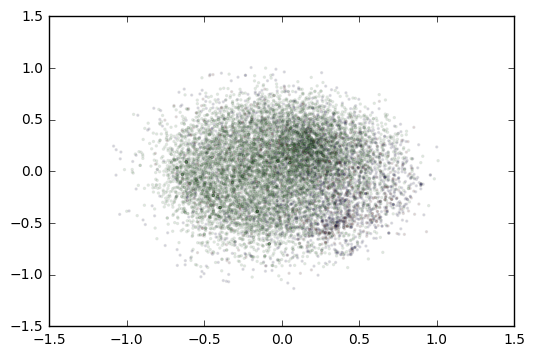

In [45]:
plt.scatter(mds.embedding_[:,0], mds.embedding_[:,1], s=2, alpha=0.1,c=np.array(labels)+5)

In [48]:
mds.embedding_.shape[0]

10726

In [76]:
y = np.array(labels)
# y[np.where(y==0)[0]]

labels0 = y[np.where(y==0)[0]]
labels1 = y[np.where(y==1)[0]]
labels2 = y[np.where(y==2)[0]]
y[np.where(y==0)]

array([0, 0, 0, ..., 0, 0, 0])

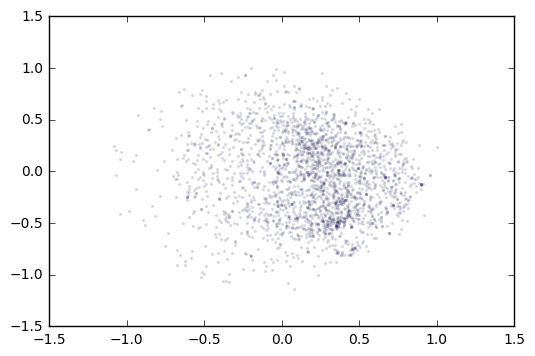

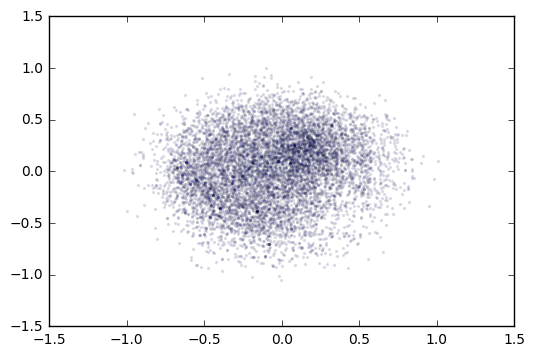

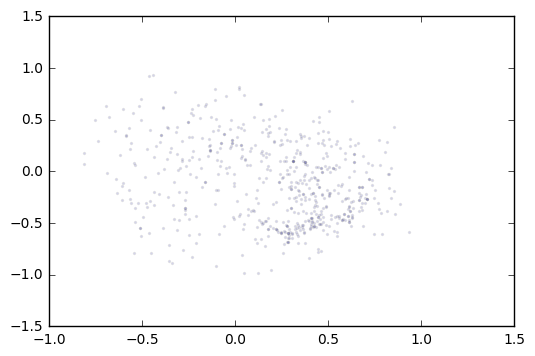

In [79]:
mds_label0 = y[np.where(y==0)[0]]
mds_label1 = y[np.where(y==1)[0]]
mds_label2 = y[np.where(y==2)[0]]
plt.scatter(mds.embedding_[:,0][np.where(y==0)[0]], mds.embedding_[:,1][np.where(y==0)[0]], s=2, alpha=0.1)
plt.show()
plt.scatter(mds.embedding_[:,0][np.where(y==1)[0]], mds.embedding_[:,1][np.where(y==1)[0]], s=2, alpha=0.1)
plt.show()

plt.scatter(mds.embedding_[:,0][np.where(y==2)[0]], mds.embedding_[:,1][np.where(y==2)[0]], s=2, alpha=0.1)

### Make dist from sim

In [ ]:
for dist_file in glob.glob('../datasets/apple-rock-pear/cos_dist*'):
    dist = np.load(dist_file)
    sim = 1-dist
    sim_filename = dist_file.replace('dist', 'sim')
    np.save(sim_filename, sim)
    print(dist_file, sim_filename)

### Clipped datasets

In [115]:
for dist_file in glob.glob('../datasets/apple-rock-pear/cos_dist*'):
    dist = np.load(dist_file)
    dist[dist>1] = 1
    filename = dist_file.replace('cos_dist', 'clipped_cos_dist')
    np.save(filename, dist)
    print(dist_file, filename)

../datasets/apple-rock-pear/cos_dist_w_3_s_False.npy ../datasets/apple-rock-pear/clipped_cos_dist_w_3_s_False.npy
../datasets/apple-rock-pear/cos_dist_w_2_s_False.npy ../datasets/apple-rock-pear/clipped_cos_dist_w_2_s_False.npy
../datasets/apple-rock-pear/cos_dist_w_4_s_False.npy ../datasets/apple-rock-pear/clipped_cos_dist_w_4_s_False.npy
../datasets/apple-rock-pear/cos_dist_w_3_s_True.npy ../datasets/apple-rock-pear/clipped_cos_dist_w_3_s_True.npy
../datasets/apple-rock-pear/cos_dist_w_4_s_True.npy ../datasets/apple-rock-pear/clipped_cos_dist_w_4_s_True.npy
../datasets/apple-rock-pear/cos_dist_w_2_s_True.npy ../datasets/apple-rock-pear/clipped_cos_dist_w_2_s_True.npy


In [116]:
for dist_file in glob.glob('../datasets/apple-rock-pear/clipped_cos_dist*'):
    dist = np.load(dist_file)
    sim = 1-dist
    sim_filename = dist_file.replace('dist', 'sim')
    np.save(sim_filename, sim)
    print(dist_file, sim_filename)

../datasets/apple-rock-pear/clipped_cos_dist_w_2_s_False.npy ../datasets/apple-rock-pear/clipped_cos_sim_w_2_s_False.npy
../datasets/apple-rock-pear/clipped_cos_dist_w_4_s_True.npy ../datasets/apple-rock-pear/clipped_cos_sim_w_4_s_True.npy
../datasets/apple-rock-pear/clipped_cos_dist_w_3_s_True.npy ../datasets/apple-rock-pear/clipped_cos_sim_w_3_s_True.npy
../datasets/apple-rock-pear/clipped_cos_dist_w_3_s_False.npy ../datasets/apple-rock-pear/clipped_cos_sim_w_3_s_False.npy
../datasets/apple-rock-pear/clipped_cos_dist_w_2_s_True.npy ../datasets/apple-rock-pear/clipped_cos_sim_w_2_s_True.npy
../datasets/apple-rock-pear/clipped_cos_dist_w_4_s_False.npy ../datasets/apple-rock-pear/clipped_cos_sim_w_4_s_False.npy
